## Data extraction & pre-processing

In [5]:
# Resolving package dependecies
# !pip3 install --upgrade pip
# !pip3 install -q plotly wordcloud
# !pip3 install seaborn

In [6]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as colors
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [7]:
books_data = pd.read_csv("data/books.csv", on_bad_lines='skip')
books_data.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [8]:
print(books_data.columns)
# rename columns
books_data = books_data.rename(columns={
    'bookID': 'book_id',
    'title': 'title',
    'authors': 'authors',
    'average_rating': 'average_rating',
    'isbn': 'isbn',
    'isbn13': 'isbn13',
    'language_code': 'language_code',
    '  num_pages': 'num_of_pages',
    'ratings_count': 'ratings_count',
    'text_reviews_count': 'text_reviews_count',
    'publication_date': 'publication_date',
    'publisher': 'publisher'
})

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')


In [9]:
books_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   book_id             11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7   num_of_pages        11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [10]:
print(f"dataset contains {books_data.shape[0]} rows and {books_data.shape[1]} columns")

dataset contains 11123 rows and 12 columns


In [12]:
# handling missing values
print(books_data.isnull().sum())  # Identify missing values

books_data['publication_date'] = books_data['publication_date'].fillna('Unknown')

# remove data with num ratings less than 10
books_data = books_data[books_data['ratings_count'] >= 10]


book_id               0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_of_pages          0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


In [13]:
# Handle abnormal values for visualization
books_data['average_rating'] = books_data['average_rating'].clip(1.0, 5.0)  # Ratings between 1 and 5
books_data['ratings_count'] = books_data['ratings_count'].clip(lower=0)     # No negative ratings
books_data['num_of_pages'] = books_data['num_of_pages'].clip(lower=0)       # No negative page counts

In [14]:
# Handle abnormal values
books_data = books_data[
    (books_data['average_rating'] >= 0.0) & 
    (books_data['average_rating'] <= 5.0)  # Ratings are between 1 and 5
]

In [15]:
# Author based aggregations
author_stats = books_data.groupby('authors').agg({
    'book_id': 'count',                 # Number of books published
    'average_rating': 'mean',          # Average rating of books
    'ratings_count': 'sum',            # Total number of ratings
    'text_reviews_count': 'sum',       # Total number of reviews
    'num_of_pages': 'mean'       # Average of book length
}).rename(columns={
    'book_id': 'total_books',
    'average_rating': 'avg_rating',
    'ratings_count': 'total_ratings',
    'text_reviews_count': 'total_reviews',
    'num_of_pages' : 'average_book_length'

}).reset_index()

print(author_stats.head())


                                             authors  total_books  avg_rating  \
0                        A.B. Yehoshua/Hillel Halkin            2        3.60   
1       A.D.P. Briggs/Leo Tolstoy/Fyodor Dostoyevsky            1        3.76   
2  A.E. Cunningham/Harlan Ellison/Charles F. Mill...            1        4.15   
3                                        A.J. Jacobs            1        3.76   
4                                         A.M. Homes            1        3.28   

   total_ratings  total_reviews  average_book_length  
0           1308            176                416.0  
1             17              1                256.0  
2             13              2                232.0  
3          24243           2326                389.0  
4           3282            518                256.0  


In [16]:
#identify High-Performing Authors: average rating above 4.0 or more than 10 books (subject to change)
high_performers = author_stats[
    (author_stats['avg_rating'] >= 4.0) &
    (author_stats['total_books'] > 10)
]
print(high_performers)


                                 authors  total_books  avg_rating  \
1346                       Douglas Adams           14    4.229286   
1364                           Dr. Seuss           15    4.120667   
2279       Hiromu Arakawa/Akira Watanabe           12    4.565833   
2385                        Isaac Asimov           14    4.113571   
2437                        J.K. Rowling           11    4.513636   
2455                      J.R.R. Tolkien           17    4.395882   
2459  J.R.R. Tolkien/Christopher Tolkien           14    4.057143   
2516                   James A. Michener           11    4.056364   
2626                         Jane Austen           12    4.232500   
2977                         John McPhee           11    4.146364   
3657                        Lynsay Sands           12    4.025833   
4004                     Mercedes Lackey           29    4.039310   
4346                        Nora Roberts           15    4.005333   
4419                      P.G. Wod

In [17]:
# Performance Score = avg_rating x w_1 + log_10(1 + total_books) x w_2
# where w_1 and w_2 are weights of the average rating and total books
# normalize variables to ensure they are comparable
w1 = 0.7  # Weight for average rating
w2 = 0.3  # Weight for total books

# Add a small constant to avoid log(0)
author_stats['performance_score'] = (
    (high_performers['avg_rating'] * w1) + 
    (np.log1p(high_performers['total_books']) * w2)  # log1p(x) = log(1 + x)
)

# Get the top 10 highest performers based on the calculated score
top_performers = author_stats.nlargest(10, 'performance_score')

# Display the top 10 performers
print("Top 10 Highest Performing Authors:")
print(top_performers[['authors', 'avg_rating', 'total_books', 'performance_score']])

Top 10 Highest Performing Authors:
                            authors  avg_rating  total_books  \
5101               Rumiko Takahashi    4.190000           38   
4419                 P.G. Wodehouse    4.152821           39   
2279  Hiromu Arakawa/Akira Watanabe    4.565833           12   
2455                 J.R.R. Tolkien    4.395882           17   
2437                   J.K. Rowling    4.513636           11   
4004                Mercedes Lackey    4.039310           29   
5720                      Tite Kubo    4.326429           14   
5625                Terry Pratchett    4.113043           23   
1346                  Douglas Adams    4.229286           14   
2626                    Jane Austen    4.232500           12   

      performance_score  
5101           4.032068  
4419           4.013638  
2279           3.965568  
2455           3.944229  
2437           3.905017  
4004           3.847876  
5720           3.840915  
5625           3.832547  
1346           3.772915  


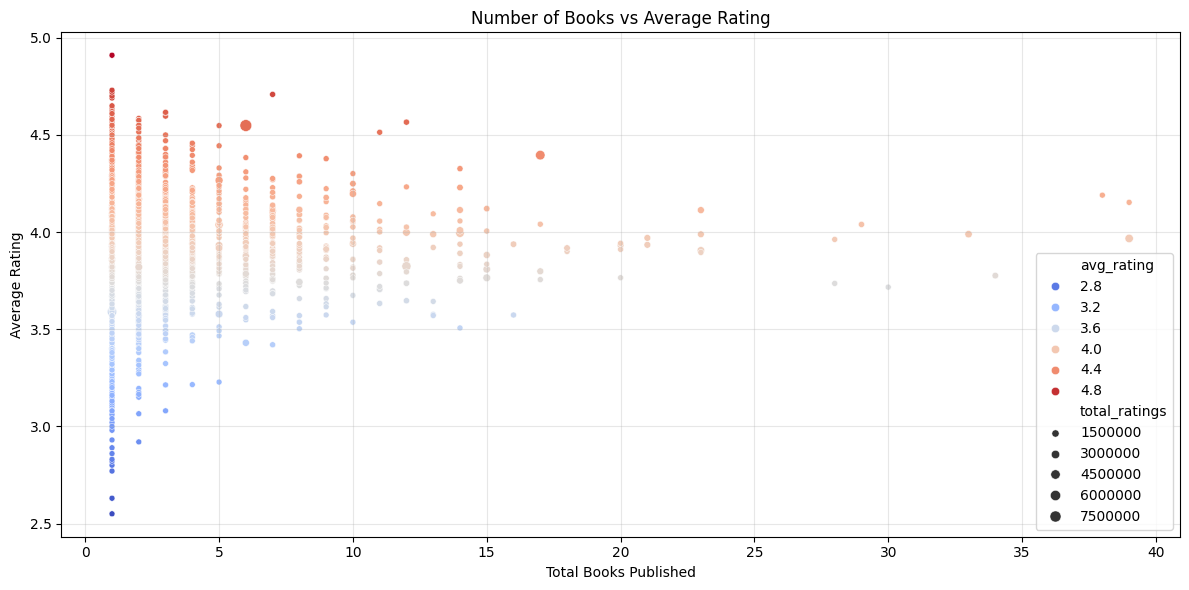

In [18]:
# Visualization: Number of Books vs. Average Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=author_stats, 
    x='total_books', 
    y='avg_rating', 
    size='total_ratings', 
    hue='avg_rating', 
    palette='coolwarm'
)
plt.title("Number of Books vs Average Rating")
plt.xlabel("Total Books Published")
plt.ylabel("Average Rating")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

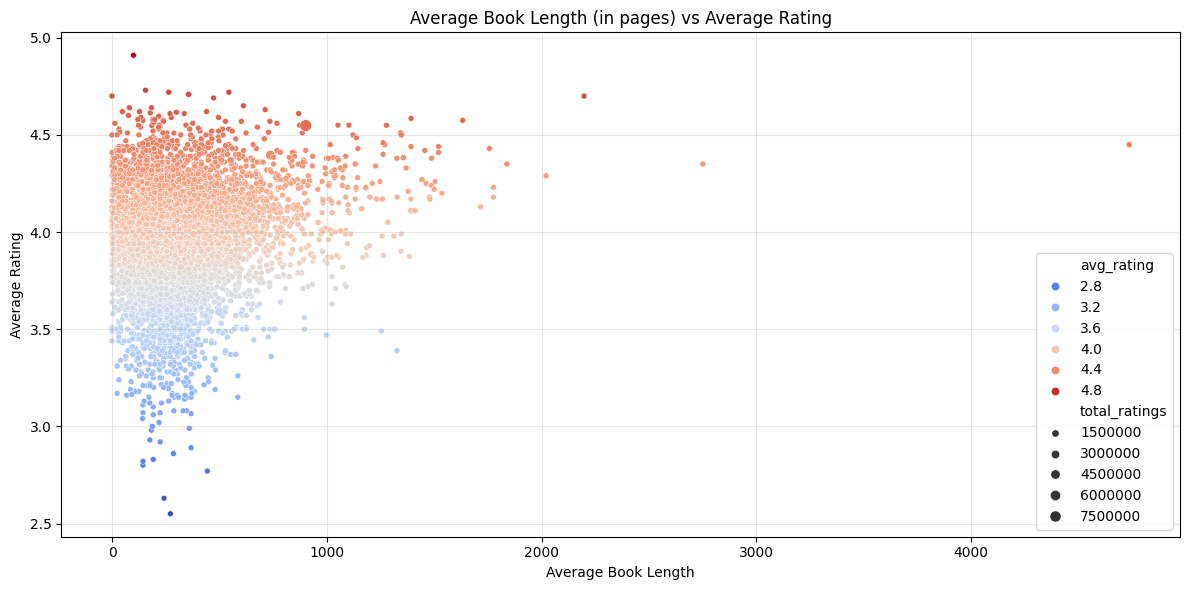

In [19]:
# Visualization: Average book length vs. Average book rating
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=author_stats, 
    x='average_book_length', 
    y='avg_rating', 
    size='total_ratings', 
    hue='avg_rating', 
    palette='coolwarm'
)
plt.title("Average Book Length (in pages) vs Average Rating")
plt.xlabel("Average Book Length")
plt.ylabel("Average Rating")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

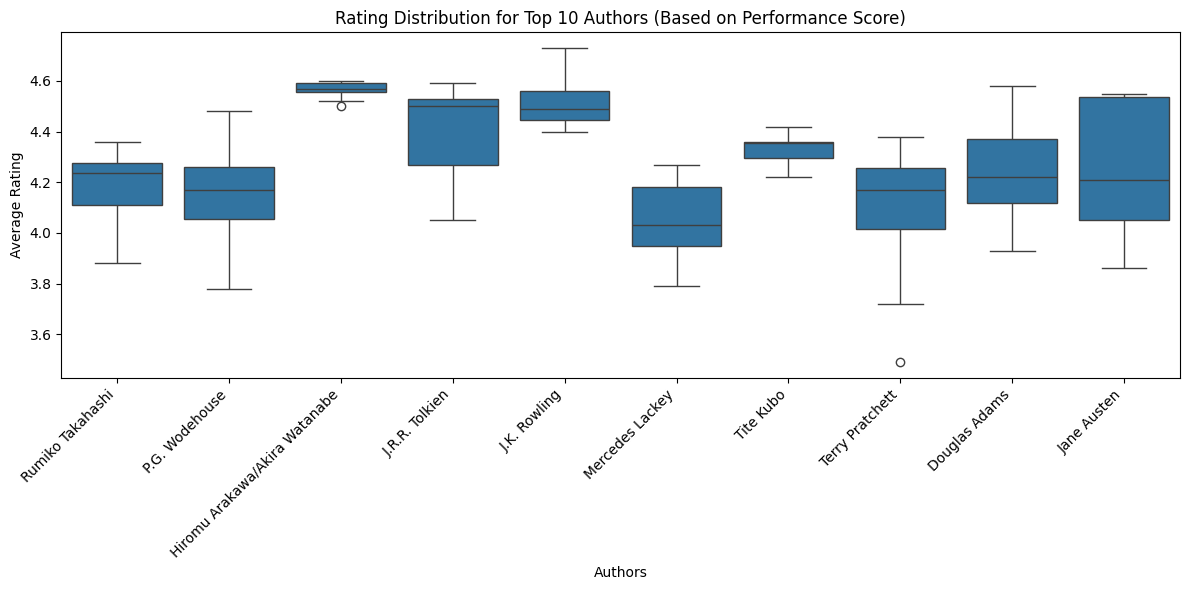

In [28]:
# Visualization: Rating Distribution for Top 10 Authors
top_performers = author_stats.nlargest(10, 'performance_score')

top_authors_data = books_data[books_data['authors'].isin(top_performers['authors'])]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=top_authors_data, 
    x='authors', 
    y='average_rating', 
    order=top_performers['authors']
)
plt.title("Rating Distribution for Top 10 Authors (Based on Performance Score)")
plt.xlabel("Authors")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


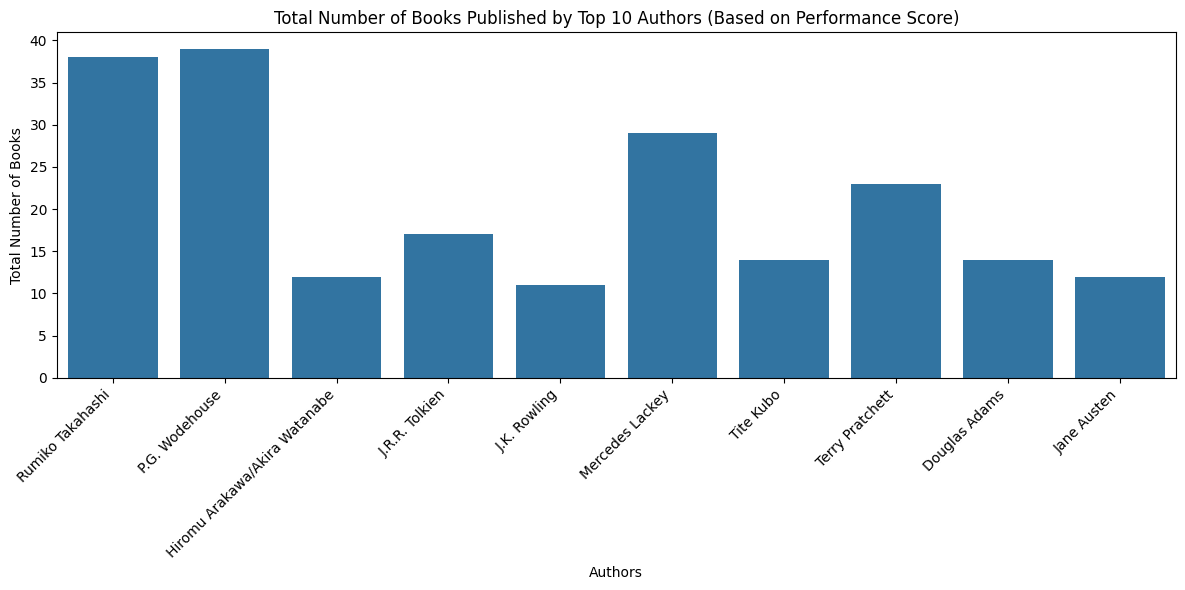

In [29]:
# Get the top 10 performers based on performance score
top_performers = author_stats.nlargest(10, 'performance_score')

# Filter the dataset for only the top 10 authors
top_authors_data = author_stats[author_stats['authors'].isin(top_performers['authors'])]

# Plotting the boxplot for total number of books
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_performers,  # Use the top_performers DataFrame directly
    x='authors', 
    y='total_books', 
    order=top_performers['authors']  # Ensure consistent order
)
plt.title("Total Number of Books Published by Top 10 Authors (Based on Performance Score)")
plt.xlabel("Authors")
plt.ylabel("Total Number of Books")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Histogram shows the reason specifically the two top authors are considered the number 1 and 2, because they have a good average rating 
# and lots of books

## Analysis Plan (subject to change)
Examples of analysis:
- Correlations: Use corr() to check relationships between variables.
- Trend Analysis: Plot ratings vs. the number of books using matplotlib or seaborn.
- Clustering: Group authors by patterns (e.g., ratings, genres) using k-means.
- Regression Analysis: Check if the number of books predicts higher ratings._

Correlation Matrix:
                     avg_rating  total_books  total_ratings  total_reviews  \
avg_rating             1.000000    -0.008648       0.023220       0.012182   
total_books           -0.008648     1.000000       0.354277       0.410177   
total_ratings          0.023220     0.354277       1.000000       0.886243   
total_reviews          0.012182     0.410177       0.886243       1.000000   
average_book_length    0.161378     0.033347       0.049932       0.047979   

                     average_book_length  
avg_rating                      0.161378  
total_books                     0.033347  
total_ratings                   0.049932  
total_reviews                   0.047979  
average_book_length             1.000000  


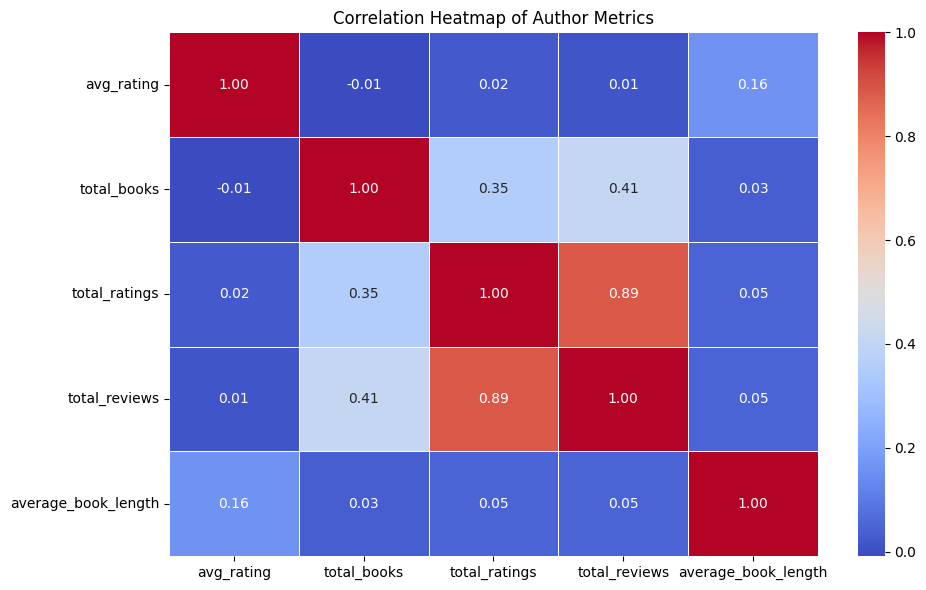

In [21]:
# Correlation Analysis
# numeric_cols = ['avg_rating', 'total_books', 'total_ratings', 'total_reviews', 'performance_score', 'average_book_length']
numeric_cols = ['avg_rating', 'total_books', 'total_ratings', 'total_reviews', 'average_book_length']
# Calculate correlations
correlation_matrix = author_stats[numeric_cols].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Heatmap for visualizing correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Author Metrics")
plt.tight_layout()
plt.show()

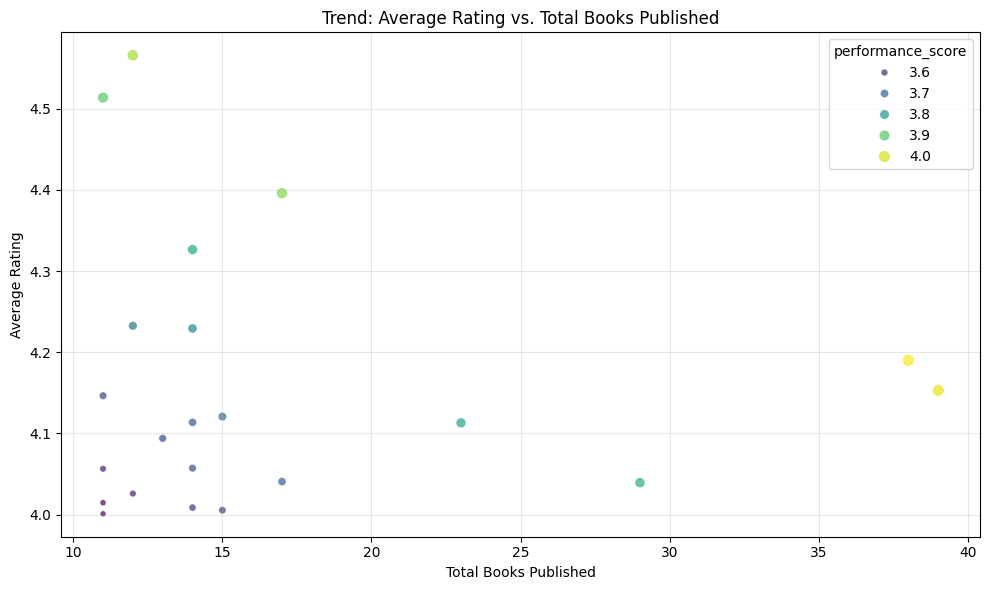

In [31]:
# Trend Analysis: Ratings vs. Number of Books
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=author_stats, 
    x='total_books', 
    y='avg_rating', 
    size='performance_score', 
    hue='performance_score', 
    palette='viridis', 
    alpha=0.7
)
plt.title("Trend: Average Rating vs. Total Books Published")
plt.xlabel("Total Books Published")
plt.ylabel("Average Rating")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


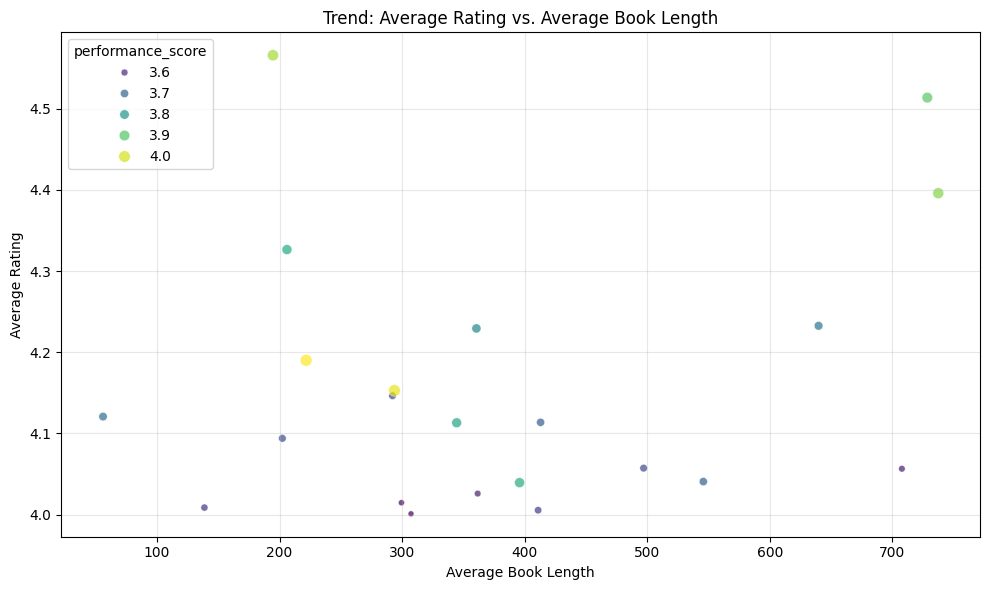

In [22]:
# Trend Analysis: Average Ratings vs. Average Book Length
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=author_stats, 
    x='average_book_length', 
    y='avg_rating', 
    size='performance_score', 
    hue='performance_score', 
    palette='viridis', 
    alpha=0.7
)
plt.title("Trend: Average Rating vs. Average Book Length")
plt.xlabel("Average Book Length")
plt.ylabel("Average Rating")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

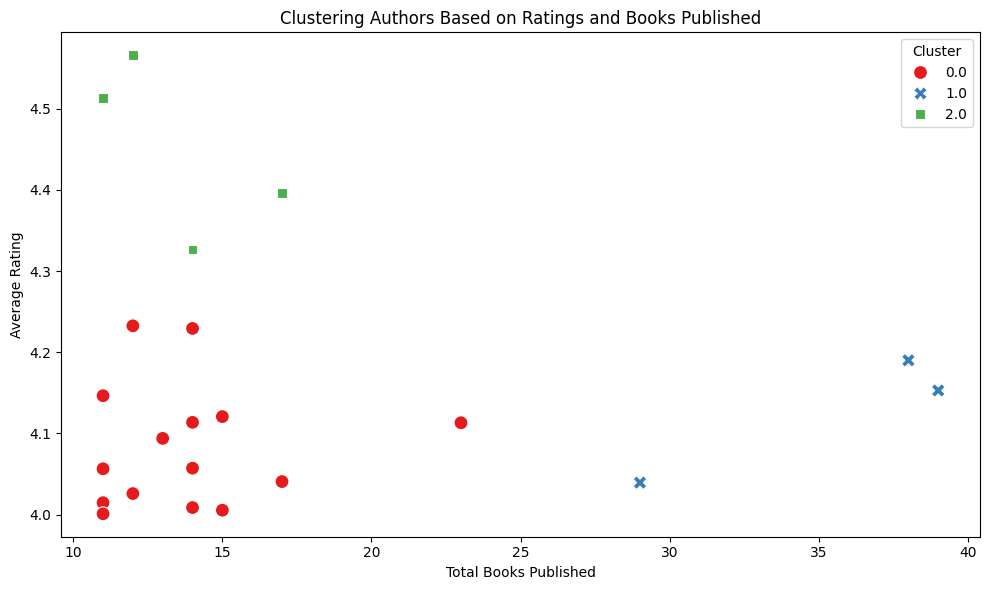


Authors in Cluster 0:
                                 authors  avg_rating  total_books  \
1346                       Douglas Adams    4.229286           14   
1364                           Dr. Seuss    4.120667           15   
2385                        Isaac Asimov    4.113571           14   
2459  J.R.R. Tolkien/Christopher Tolkien    4.057143           14   
2516                   James A. Michener    4.056364           11   

      performance_score  
1346           3.772915  
1364           3.716243  
2385           3.691915  
2459           3.652415  
2516           3.584927  

Authors in Cluster 1:
               authors  avg_rating  total_books  performance_score
4004   Mercedes Lackey    4.039310           29           3.847876
4419    P.G. Wodehouse    4.152821           39           4.013638
5101  Rumiko Takahashi    4.190000           38           4.032068

Authors in Cluster 2:
                            authors  avg_rating  total_books  \
2279  Hiromu Arakawa/Akira W

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
clustering_features = author_stats[['avg_rating', 'total_books', 'performance_score']]

# Handle NaN values (drop rows with NaN)
clustering_features = clustering_features.dropna()

# Scale the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters as needed
author_stats.loc[clustering_features.index, 'cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=author_stats.dropna(subset=['cluster']),  # Exclude rows without cluster assignment
    x='total_books', 
    y='avg_rating', 
    hue='cluster', 
    palette='Set1', 
    style='cluster', 
    s=100
)
plt.title("Clustering Authors Based on Ratings and Books Published")
plt.xlabel("Total Books Published")
plt.ylabel("Average Rating")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Show sample of authors in each cluster
for cluster in range(3):  # Adjust range based on the number of clusters
    print(f"\nAuthors in Cluster {cluster}:")
    print(author_stats[author_stats['cluster'] == cluster][['authors', 'avg_rating', 'total_books', 'performance_score']].head())


Regression Model Evaluation:
R-squared: 0.00
Mean Squared Error: 0.07


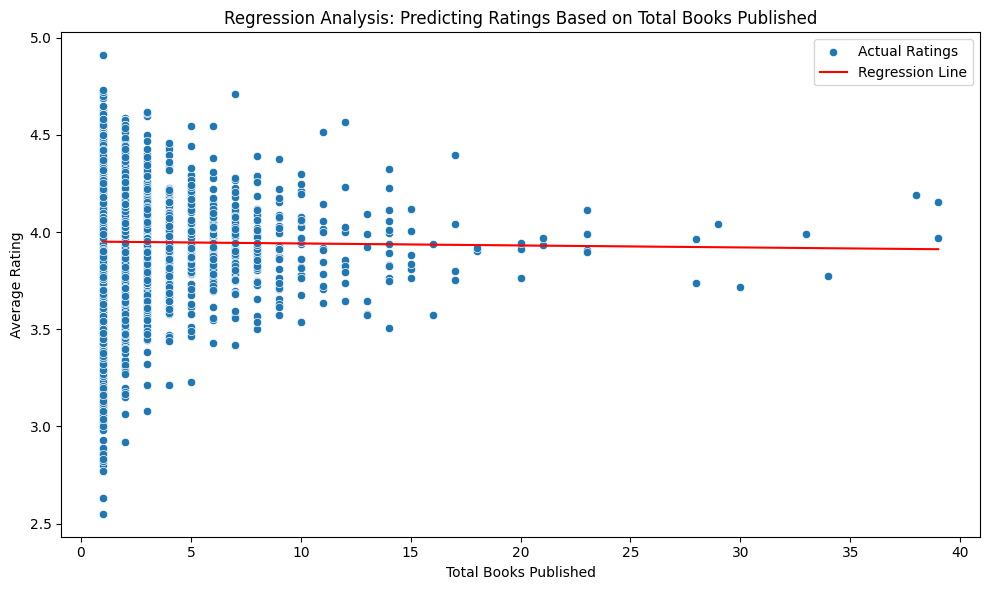

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Prepare data for regression
X = author_stats[['total_books']]  # Predictor variable: total_books
y = author_stats['avg_rating']    # Target variable: avg_rating

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict ratings based on the model
y_pred = model.predict(X)

# Evaluate the model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print model evaluation
print(f"Regression Model Evaluation:")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['total_books'], y=y, label="Actual Ratings")
sns.lineplot(x=X['total_books'], y=y_pred, color='red', label="Regression Line")
plt.title("Regression Analysis: Predicting Ratings Based on Total Books Published")
plt.xlabel("Total Books Published")
plt.ylabel("Average Rating")
plt.legend()
plt.tight_layout()
plt.show()


Regression Model Evaluation:
R-squared: 0.03
Mean Squared Error: 0.07


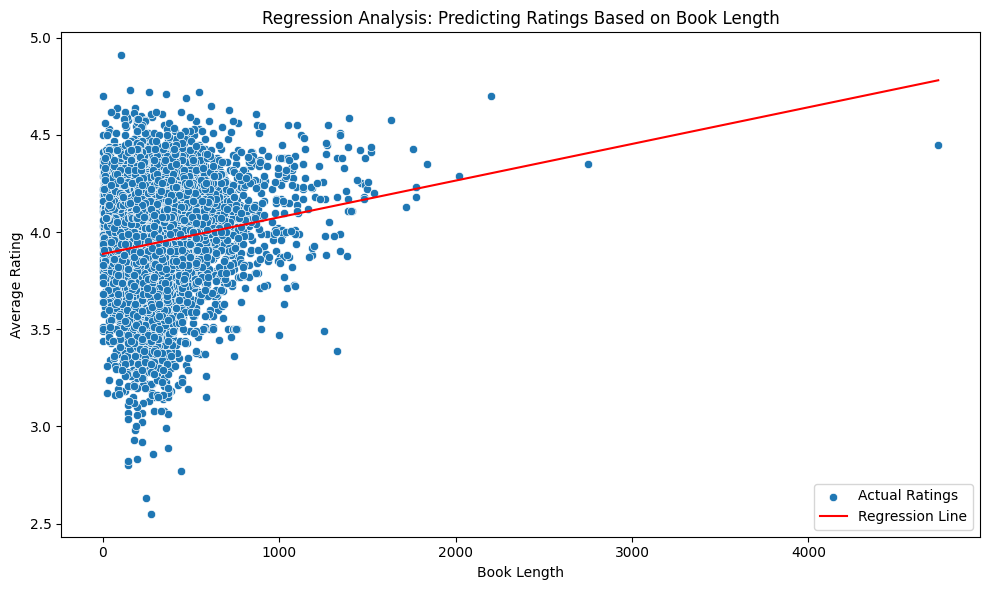

In [25]:
# Regression Analysis based on average book length
# Prepare data for regression
X = author_stats[['average_book_length']]  # Predictor variable: average_book_length
y = author_stats['avg_rating']    # Target variable: avg_rating

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict ratings based on the model
y_pred = model.predict(X)

# Evaluate the model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print model evaluation
print(f"Regression Model Evaluation:")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['average_book_length'], y=y, label="Actual Ratings")
sns.lineplot(x=X['average_book_length'], y=y_pred, color='red', label="Regression Line")
plt.title("Regression Analysis: Predicting Ratings Based on Book Length")
plt.xlabel("Book Length")
plt.ylabel("Average Rating")
plt.legend()
plt.tight_layout()
plt.show()


